# Monitoring coastal erosion along Africa's coastline

* **Products used:**
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc)

## Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

While coastlines can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Real_world_examples/Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below. This can be a particular problem in cloudy regions or areas where wet season clouds prevent optical satellites from taking clear images for many months of the year.

### Sentinel-1 use case
Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather. Radar data is readily available from the ESA/EC Copernicus program’s Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.

### Description

In this example, we use data from the Sentinel-1 satellites to build a classifier that can determine whether a pixel is water or land in radar data. Specifically, this notebook uses an analysis-ready radar product known as backscatter, which describes the strength of the signal recieved by the satellite. The worked example takes users through the code required to:

1. Load Sentinel-1 backscatter data for an area of interest
2. Visualise the returned data.
3. Perform pre-processing steps on the Sentinel-1 bands.
4. Design a classifier to distinguish land and water.
5. Apply the classifier to the area of interest and interpret the results.
6. Investigate how to identify coastal change or the effect of tides.

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
First we need to install additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository that will allow us to estimate rates of coastal change. 
> **Note:** If you run into any error messages in this analysis, try restarting the notebook by clicking `Kernel`, then `Restart Kernel and Clear All Outputs`.

In [42]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Now we can load key Python packages and supporting functions for the analysis.

In [43]:
%matplotlib inline

import os
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu

import warnings
warnings.filterwarnings("ignore")

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [44]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:44315' processes=1 threads=4, memory=28.14 GB>

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [45]:
dc = datacube.Datacube(app="Coastal_erosion")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2013', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.

In [46]:
# # Define the area of interest
# lat = 14.29
# lon = -16.92
# buffer = 0.015

# Define the area of interest: around Comoros
lat = -12.4
lon = 43.736
buffer = 0.04

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2022')
time_step = '1Y'
# time_step = '6M'
# tide_range = (0.25, 0.75)
tide_range = (0, 1)


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [47]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-1 data
The first step in this analysis is to load in Sentinel-1 data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from Sentinel-1 for the area and time specified. Sentinel-1 backscatter data has two measurements, VV and VH, which correspond to the polarisation of the light sent and received by the satellite. VV refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas VH refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back. These two measurement bands can tell us different information about the area we’re studying.

In [48]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh'], # loading vh for experiement
    'resolution': (-20, 20),
}

# Identify the most common projection system in the input query
output_crs = "EPSG:6933" #mostcommon_crs(dc=dc, product='s2_l2a', query=query)

# Load available data
S1 = load_ard(dc=dc,
              products=['s1_rtc'],
              output_crs=output_crs,
              resampling='bilinear',
              #align=(5, 5),
              #mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              dtype='native',
              **query)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 191 time steps as a dask array


Once the load is complete, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [49]:
print(S1)

<xarray.Dataset>
Dimensions:      (time: 191, y: 499, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-02T02:41:35.636685 ... 2021-12...
  * y            (y) float64 -1.565e+06 -1.565e+06 ... -1.575e+06 -1.575e+06
  * x            (x) float64 4.216e+06 4.216e+06 ... 4.224e+06 4.224e+06
    spatial_ref  int32 6933
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 499, 387), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Model tide heights and filter scenes by tidal range

Setting tide modelling location from dataset centroid: 43.74, -12.40
<xarray.DataArray 'tide_height' ()>
array(-0.747)
Coordinates:
    quantile  float64 0.0 <xarray.DataArray 'tide_height' ()>
array(2.069)
Coordinates:
    quantile  float64 1.0


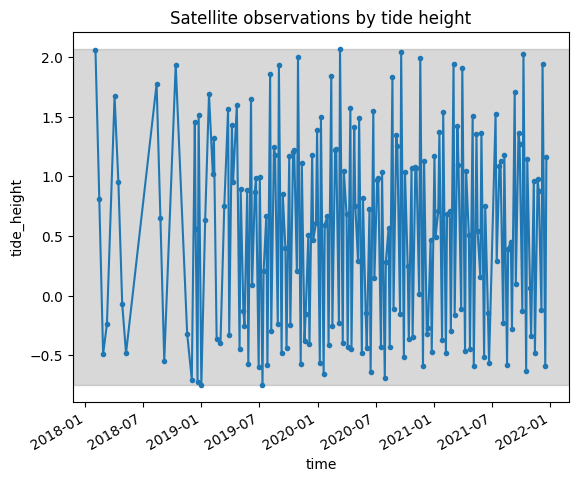

In [50]:
# Calculate tides for each timestep in the satellite dataset
S1 = tidal_tag(ds=S1, tidepost_lat=None, tidepost_lon=None)

# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = S1.tide_height.quantile(tide_range) 
print(min_tide, max_tide)

# Plot the resulting tide heights for each image:
S1.tide_height.plot(marker="o", markersize=3)
plt.axhspan(min_tide, max_tide, color='grey', alpha=0.3)
plt.title('Satellite observations by tide height')
plt.show()

In [51]:
# Keep timesteps larger than the min tide, and smaller than the max tide
S1 = S1.sel(time=(S1.tide_height > min_tide) &
                                       (S1.tide_height <= max_tide))
print(S1)

<xarray.Dataset>
Dimensions:      (time: 189, y: 499, x: 387)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-02T02:41:35.636685 ... 2021-12...
  * y            (y) float64 -1.565e+06 -1.565e+06 ... -1.575e+06 -1.575e+06
  * x            (x) float64 4.216e+06 4.216e+06 ... 4.224e+06 4.224e+06
    spatial_ref  int32 6933
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 499, 387), meta=np.ndarray>
    tide_height  (time) float64 2.063 0.813 -0.49 -0.237 ... 1.94 -0.588 1.166
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Preprocessing the data through filtering

### Speckle Filtering using Lee Filter

In [52]:
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [53]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = xr.ufuncs.isfinite(S1)
S1 = S1.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

# removing null values so the thresholding function will work
# # Null pixels should remain null
# S1['filtered_vh'] = S1.filtered_vh.where(valid.vh)

In [54]:
# Scale to plot data in decibels
S1['filtered_vh'] = 10 * xr.ufuncs.log10(S1.filtered_vh)

## Explore automatic thresholding methods for shoreline extraction

### plot histogram of filtered values

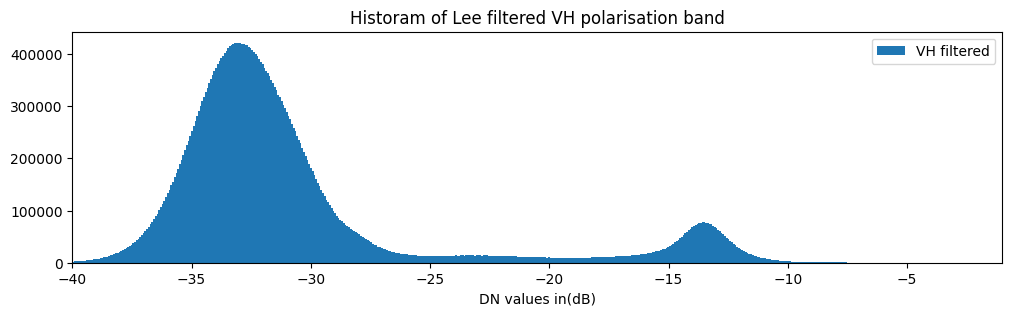

In [55]:
fig = plt.figure(figsize=(12, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Historam of Lee filtered VH polarisation band");

In [56]:
# minimum thresholding
threshold_vh = threshold_minimum(S1.filtered_vh.values)
# otsu thresholding
threshold_vh_o = threshold_otsu(S1.filtered_vh.values)
print('threshold identified by minimum thresholding method: ',threshold_vh)
print('threshold identified by otsu thresholding method: ', threshold_vh_o)

threshold identified by minimum thresholding method:  -19.498745
threshold identified by otsu thresholding method:  -24.303265


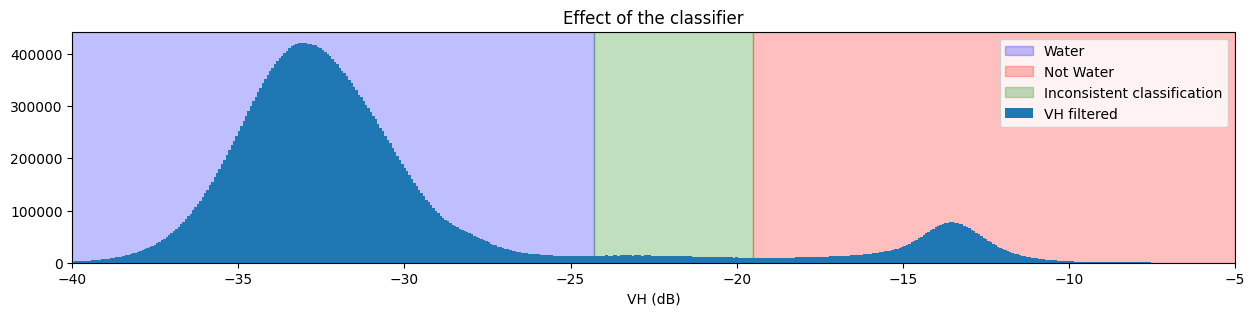

In [57]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.xlim(-40,-5)
ax.axvspan(xmin=-40.0, 
           xmax=np.min([threshold_vh,threshold_vh_o]), 
           alpha=0.25, 
           color="blue", 
           label="Water")
ax.axvspan(xmin=np.max([threshold_vh,threshold_vh_o]),
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
ax.axvspan(xmin=np.min([threshold_vh,threshold_vh_o]),
           xmax=np.max([threshold_vh,threshold_vh_o]),
           alpha=0.25,
           color="green",
           label="Inconsistent classification")
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, e.g. effects of wind on the water. To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

In [68]:
time_step='6M'

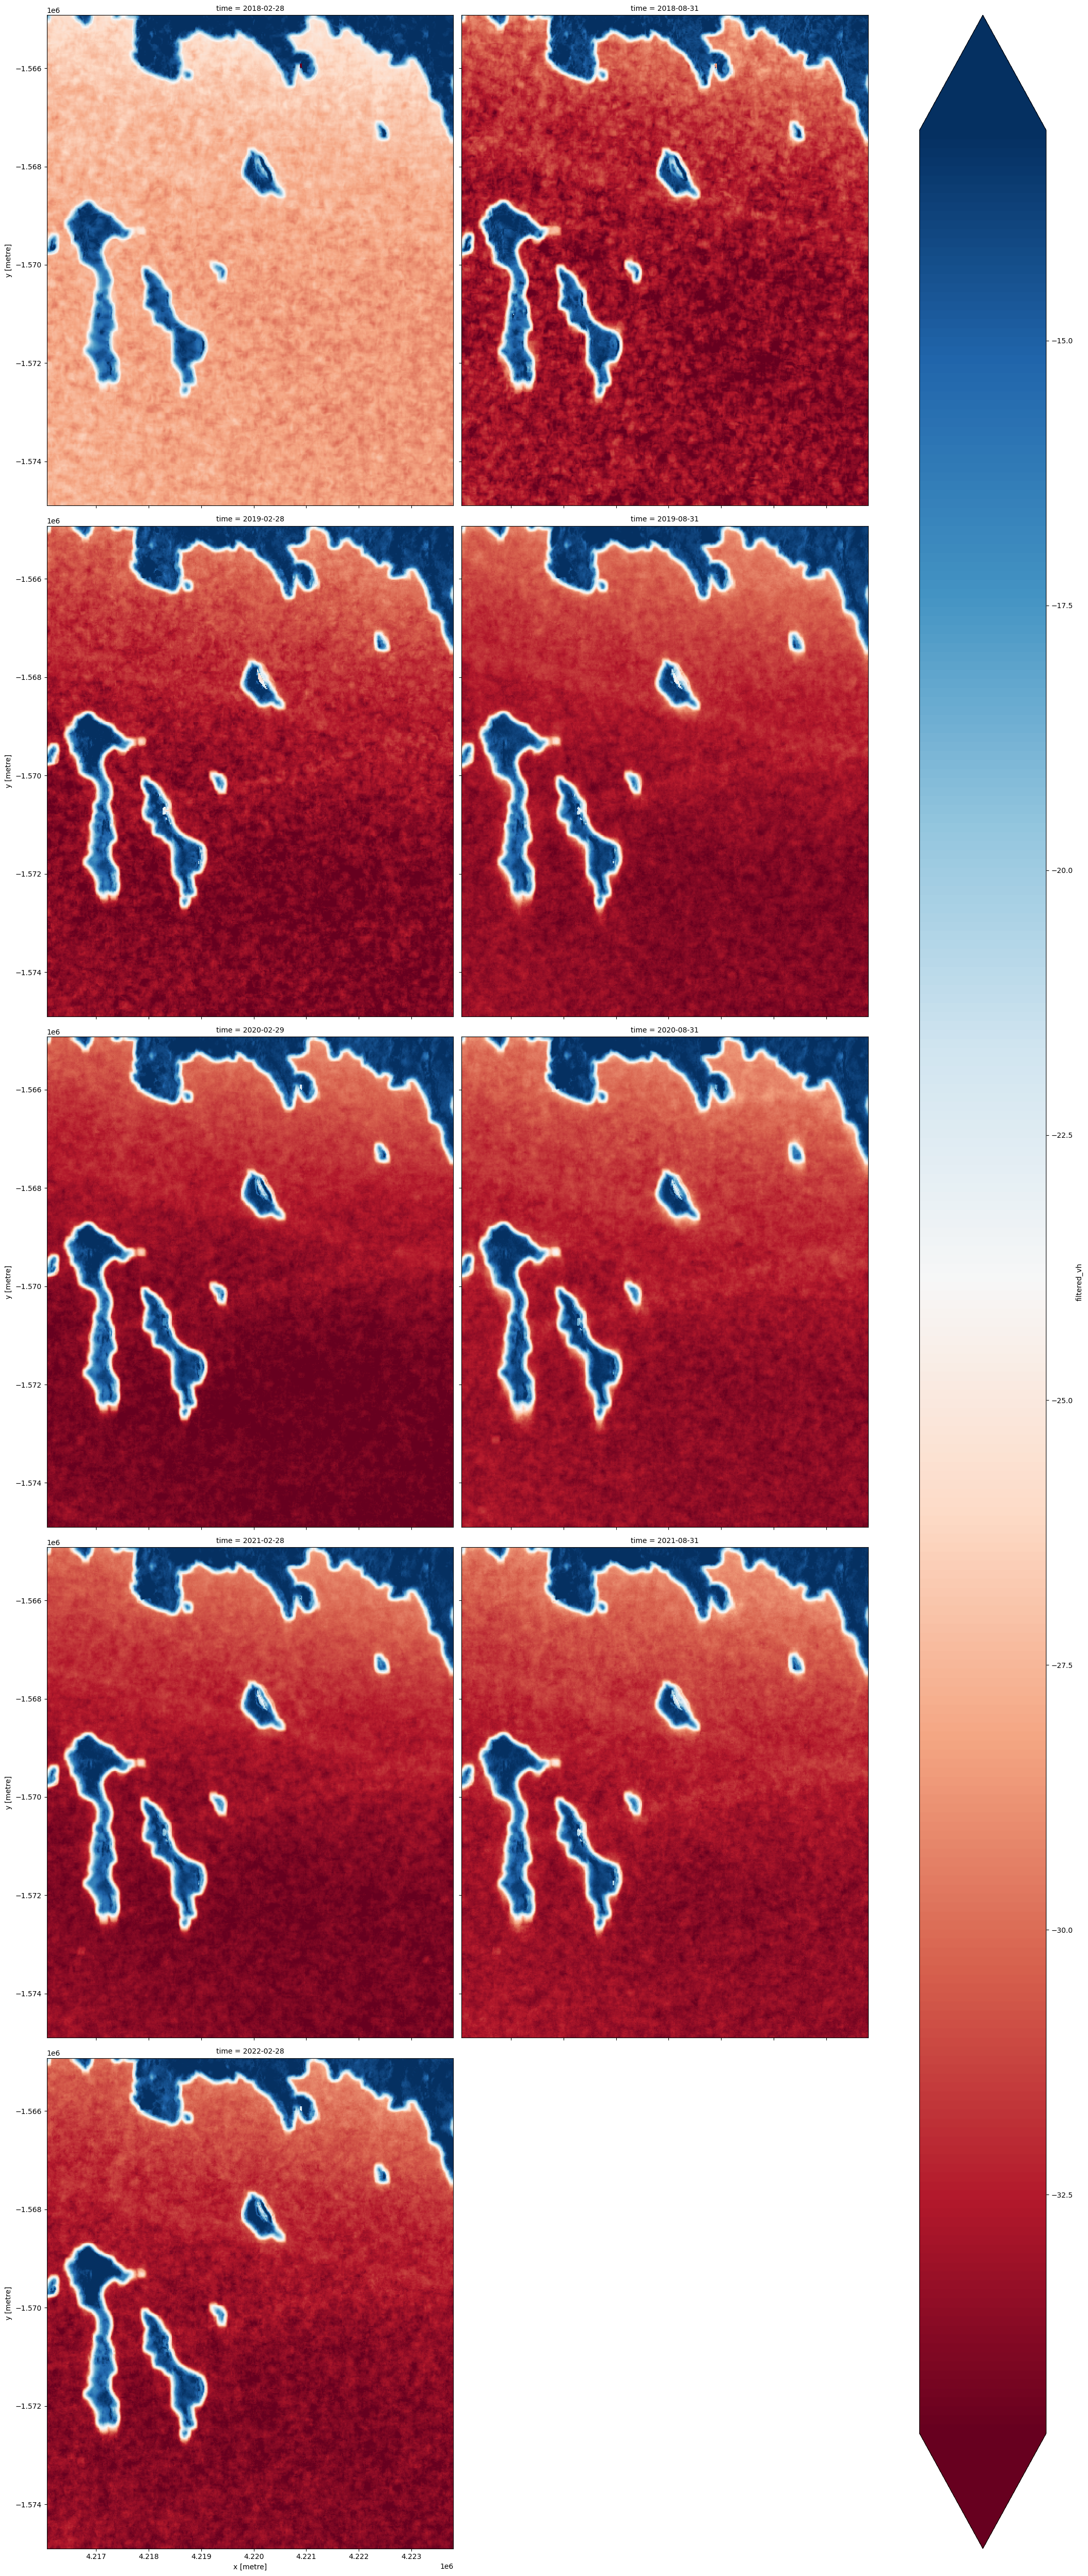

In [69]:
# Combine into summary images by `time_step`
ds_summaries = (S1[['filtered_vh']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )

# Shut down Dask client now that we have processed the data we need
client.close()

# # Rename time attribute as year
# ds_summaries['year'] = ds_summaries.time.dt.year
# ds_summaries = ds_summaries.rename(time='year')

# simplified checking if frequency is lower than yearly
if 'Y' in time_step:
    time_str='year'
    ds_summaries['time'] = ds_summaries.time.dt.year
    ds_summaries = ds_summaries.rename(time='year')
else:
    time_str='time'
    
# Plot the output summary images
ds_summaries.filtered_vh.plot(
                        col=time_str,
                       cmap='RdBu',
                       col_wrap=2,
                       robust=True, size=10)
plt.show()


## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above. 
The code below identifies the boundary between land and water by tracing a line along pixels with the previously identified threshold value. 
It returns a vector file with one line for each time step:


In [70]:
contour_gdf = subpixel_contours(da=ds_summaries.filtered_vh,
                                z_values=threshold_vh,
#                                 z_values=threshold_vh_o,
                                dim=time_str,
                                crs=S1.geobox.crs,
                                affine=S1.geobox.transform,
                                output_path=f'annual_shorelines.geojson',
                                min_vertices=15)
contour_gdf=contour_gdf.set_index(time_str)
# Preview shoreline data
contour_gdf

geometry
time                                                         
2018-02-28  MULTILINESTRING ((4216912.626 -1564930.000, 42...
2018-08-31  MULTILINESTRING ((4216906.961 -1564930.000, 42...
2019-02-28  MULTILINESTRING ((4216909.357 -1564930.000, 42...
2019-08-31  MULTILINESTRING ((4216906.415 -1564930.000, 42...
2020-02-29  MULTILINESTRING ((4216906.430 -1564930.000, 42...
2020-08-31  MULTILINESTRING ((4216911.256 -1564930.000, 42...
2021-02-28  MULTILINESTRING ((4216907.296 -1564930.000, 42...
2021-08-31  MULTILINESTRING ((4216912.195 -1564930.000, 42...
2022-02-28  MULTILINESTRING ((4216905.754 -1564930.000, 42...

### Plot annual shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [71]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column=time_str,
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

## Calculate rates of coastal change (todo: update to enable finer scale change rate calculation)
To identify parts of the coastline that are changing rapidly, we can use our annual shoreline data to calculate rates of coastal change in metres per year.
This can be particularly useful to reveal hotspots of coastal retreat (e.g. erosion), or hotspots of coastal growth.

To do this, we first need to create a set of evenly spaced points at every 30 metres along the most recent shoreline in our dataset. 
These points will be used to plot rates of coastal change across our study area.

<AxesSubplot: >

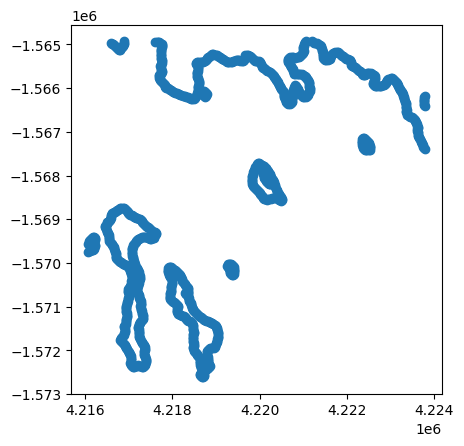

In [63]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index='2021', distance=30)
points_gdf.plot()

Now that we have a set of modelling points, we can measure distances from each of the points to each annual shoreline. 
This gives us a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of our points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because our points were created along our most recent 2021 shoreline, distances for 2021 will always have a distance of 0 m.

In [64]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2021 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(points_gdf,
                              contours_gdf=contour_gdf,
                              yearly_ds=ds_summaries,
                              baseline_year=2021,
                              water_index='filtered_vh')
points_gdf

geometry  dist_2018  dist_2019  dist_2020  \
0     POINT (4216907.878 -1564930.000)      -1.30       1.20      -1.10   
1     POINT (4216901.852 -1564959.385)      -0.40       2.52      -0.34   
2     POINT (4216894.958 -1564988.559)       0.09       5.75      -0.94   
3     POINT (4216886.117 -1565017.180)      -1.49       3.81      -0.78   
4     POINT (4216873.827 -1565044.524)      -2.46       2.46      -0.83   
...                                ...        ...        ...        ...   
1182  POINT (4218731.936 -1572494.420)      -0.76       4.27      -4.25   
1183  POINT (4218738.033 -1572523.789)      -0.60       0.11      -1.92   
1184  POINT (4218737.160 -1572553.383)       1.30       1.01      -0.84   
1185  POINT (4218723.813 -1572579.945)       0.56       0.08      -2.19   
1186  POINT (4218706.015 -1572604.044)       0.38      -1.31      -4.47   

      dist_2021  angle_mean  angle_std  
0           0.0         100         34  
1           0.0         109         32  
2           0.0         107         32  
3           0.0         112         32  
4           0.0         119         30  
...         ...         ...        ...  
1182        0.0          60         35  
1183        0.0          81         33  
1184        0.0         112         31  
1185        0.0         127         27  
1186        0.0         136         24  

[1187 rows x 7 columns]

Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [65]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf,
                                   contours_gdf=contour_gdf)
points_gdf

rate_time  sig_time  se_time outl_time  dist_2018  dist_2019  dist_2020  \
0         0.160     0.821    0.621                -1.30       1.20      -1.10   
1        -0.166     0.846    0.755                -0.40       2.52      -0.34   
2        -0.696     0.706    1.598                 0.09       5.75      -0.94   
3        -0.012     0.993    1.294                -1.49       3.81      -0.78   
4         0.409     0.743    1.086                -2.46       2.46      -0.83   
...         ...       ...      ...       ...        ...        ...        ...   
1182     -0.624     0.770    1.865                -0.76       4.27      -4.25   
1183     -0.023     0.968    0.510                -0.60       0.11      -1.92   
1184     -0.575     0.242    0.350                 1.30       1.01      -0.84   
1185     -0.395     0.584    0.611                 0.56       0.08      -2.19   
1186     -0.430     0.748    1.167                 0.38      -1.31      -4.47   

      dist_2021  angle_mean  angle_std                          geometry  
0           0.0         100         34  POINT (4216907.878 -1564930.000)  
1           0.0         109         32  POINT (4216901.852 -1564959.385)  
2           0.0         107         32  POINT (4216894.958 -1564988.559)  
3           0.0         112         32  POINT (4216886.117 -1565017.180)  
4           0.0         119         30  POINT (4216873.827 -1565044.524)  
...         ...         ...        ...                               ...  
1182        0.0          60         35  POINT (4218731.936 -1572494.420)  
1183        0.0          81         33  POINT (4218738.033 -1572523.789)  
1184        0.0         112         31  POINT (4218737.160 -1572553.383)  
1185        0.0         127         27  POINT (4218723.813 -1572579.945)  
1186        0.0         136         24  POINT (4218706.015 -1572604.044)  

[1187 rows x 11 columns]

### Plot rates of coastal change on an interactive map
Now that we have calculated rates of coastal change, we can plot these on an interactive map to identify parts of the coastline that are retreating or growing over time.

When the map appears below, hover your mouse over the coloured dots that appear along the coastline for a summary of recent coastal change at those locations. 
Red dots represent locations that are retreating (e.g. erosion), and blue dots represent locations that are growing.

![coastal_change.jpg](../Supplementary_data/Coastal_erosion/coastal_change.jpg)

In [66]:
# Add human-friendly label for plotting
points_gdf['Coastal change'] = points_gdf.apply(
    lambda x:
    f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f'by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since '
    f'<b>{contour_gdf.index[0]}</b></h4>',
    axis=1)
points_gdf.loc[points_gdf.sig_time > 0.05, 'Coastal change'] = (
    f'<h4>No significant trend of retreat or growth)</h4>')

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    tooltip=False,
    style_kwds={'opacity': 0.5},
    attr='ESRI WorldImagery')

# Add rates of change to map
points_gdf.explore(
    m=m,
    column='rate_time',
    vmin=-5,
    vmax=5,
    tooltip='Coastal change',
    cmap='RdBu',
)

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, we can export our output rates of change file so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [67]:
points_gdf.to_crs('EPSG:4326').to_file('rates_of_coastal_change_S1.geojson')

## Drawing conclusions
Here are some questions to think about:
* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat`/`lon`) and rerun the analysis.
If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/). 

For more information about the method behind this notebook, read the scientific paper:
> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')